In [1]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [7]:
# Convert to a DataFrame.
import pandas as pd
from sklearn.datasets import fetch_openml

df = fetch_openml('credit-g', as_frame=True).frame
df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [8]:
df.dtypes

checking_status           category
duration                   float64
credit_history            category
purpose                   category
credit_amount              float64
savings_status            category
employment                category
installment_commitment     float64
personal_status           category
other_parties             category
residence_since            float64
property_magnitude        category
age                        float64
other_payment_plans       category
housing                   category
existing_credits           float64
job                       category
num_dependents             float64
own_telephone             category
foreign_worker            category
class                     category
dtype: object

# **Features that are categorical and those that are Continuous**

Category - checking_status, credit_history , purpose , savings_status , employment , installment_commitment, personal_status , other_parties , residence_since , property_magnitude , other_payment_plans ,housing , existing_credits, job , num_dependents , own_telephone , foreign_worker , class

Continuous - duration, credit_amount , age

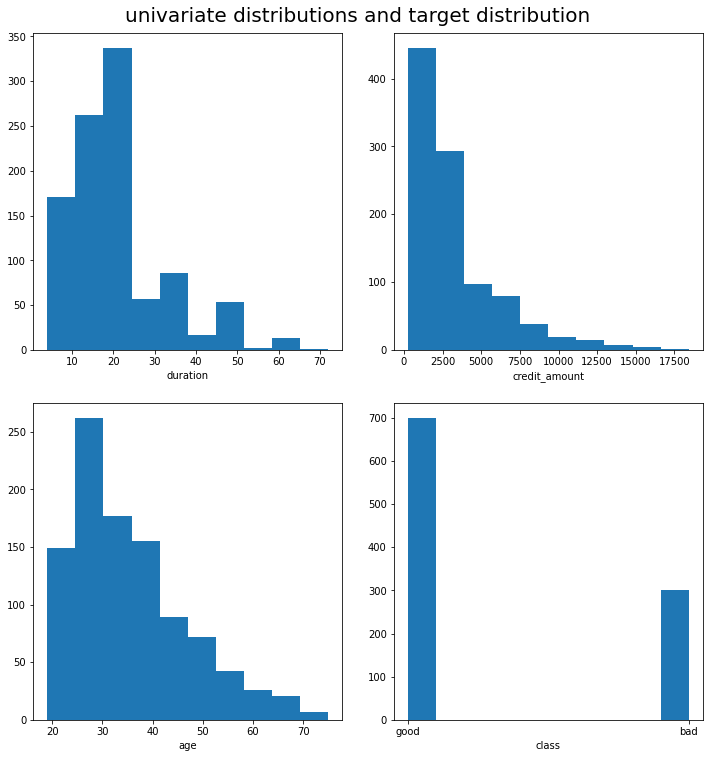

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
st = fig.suptitle("univariate distributions and target distribution", fontsize=20)

# Using columns that we need for this plot
nfeatures = df[['duration', 'credit_amount' , 'age']]
target = df['class']

# creating 4x4 grid
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.4)

# creating the normal plots in grid 1 , 2 ,3 and 4
p1 = fig.add_subplot(grid[:2,:2])
p2 = fig.add_subplot(grid[:2,2:])
p3 = fig.add_subplot(grid[2:,:2])
p4 = fig.add_subplot(grid[2:,2:])

p1.hist(nfeatures['duration'])
p2.hist(nfeatures['credit_amount'])
p3.hist(nfeatures['age'])
p4.hist(target)

p1.set_xlabel('duration')
p2.set_xlabel('credit_amount')
p3.set_xlabel('age')
p4.set_xlabel('class')
# customizing to look neat
st.set_y(0.95)
fig.subplots_adjust(top=0.92)